In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/project1/

/content/drive/My Drive/project1


In [3]:
import os
import math
import glob
import cv2
from collections import deque
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from skimage.transform import resize
from sklearn.metrics import recall_score , precision_score , confusion_matrix,mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
%matplotlib inline

In [4]:
import cv2,os
data_path='/content/drive/MyDrive/project1/datasets/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary
print(label_dict)
print(categories)
print(labels)

{'Non Glaucoma': 0, 'Glaucoma': 1}
['Non Glaucoma', 'Glaucoma']
[0, 1]


In [5]:
img_size=150
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        try:  
            img = img / 255.0
            resized=cv2.resize(img,(img_size,img_size))
            #resizing the image  into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [6]:
from skimage.feature import hog
def hogBatch(imgs):
    featureList = []
    for img in imgs:
        feature, _ = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                         block_norm='L2-Hys', visualize=True)
        featureList.append(feature)
    return featureList

In [7]:
featureList = hogBatch(data)

In [8]:
np.array(featureList).shape

(705, 10404)

In [9]:
def lbpSingle(img):
    h, w = img.shape
    #
    temp_1 = np.zeros(img.shape)
    for i in range(1, h - 1):
        for j in range(1, w - 1):
        	# Judging whether the numbers around the 3X3 matrix are greater than the center number of the matrix center
            temp_2 = (img[i - 1:i + 2, j - 1:j + 2] > img[i][j]).astype(np.int8)
            # The shape of the reorganization is a column
            temp_2 = temp_2.reshape(9)
            # Delete the central value
            temp_2 = np.delete(temp_2, 4)
            # Since the order is sorted in clockwise
            temp_2[3], temp_2[4] = temp_2[4], temp_2[3]
            temp_2[5], temp_2[7] = temp_2[7], temp_2[5]
            temp_2 = ''.join('%s' % i for i in temp_2)
            # 01 binary turn to decimal
            temp_1[i][j] = int(temp_2, 2)
    # The characteristics of this image are characterized by LBP processing
    return [temp_1.flatten()]


def lbpBatch(imgs):
    imgsFeatureList = []
    for img in imgs:
        imgsFeatureList.append(lbpSingle(img)[0])
    return imgsFeatureList

In [10]:
imgsFeatureList = lbpBatch(data)

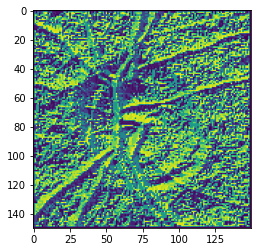

In [11]:
plt.imshow(imgsFeatureList[1].reshape(150,150))

In [12]:
X_feature_lbp = np.resize(imgsFeatureList, (705, 10404))

In [13]:
X = []

for features in imgsFeatureList:
    X.append(features)


X = np.array(X).reshape(-1, 150, 150, 1)

In [14]:
# Creating the Model 

feature_extractor = Sequential()
feature_extractor.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape= X.shape[1:]))
feature_extractor.add(MaxPooling2D(pool_size=(2, 2)))
feature_extractor.add(Conv2D(32, (3, 3), activation='relu'))
feature_extractor.add(MaxPooling2D(pool_size=(2, 2)))
feature_extractor.add(Dropout(0.25))
feature_extractor.add(Flatten())

In [15]:
X_feature = feature_extractor.predict(X)

In [16]:
X_feature = np.array(X_feature)

In [17]:
np.array(X_feature).shape

(705, 41472)

In [18]:
X_feature = np.resize(X_feature, (705, 10404))

In [19]:
features=[]
features.append(np.concatenate((featureList, X_feature)))

In [20]:
features = np.array(features).reshape((1410, 10404))

In [21]:
for i in range(0,len(target)):
  target.append(target[i])

In [22]:
np.array(target).shape

(1410,)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.40)

In [24]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test))
print('For these',n_predict, 'labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

print('Test rms of SVC = ',mean_squared_error(y_test,  svc.predict(X_test), squared=False))
print('Test recall of SVC = ',recall_score(y_test, svc.predict(X_test), average=None))
print('Test precision of SVC = ',precision_score(y_test, svc.predict(X_test), average=None))
print('confusion_matrix of SVC = ',confusion_matrix(y_test, svc.predict(X_test)))

3.57 Seconds to train SVC...
Test Accuracy of SVC =  0.6401
My SVC predicts:      [0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0
 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1
 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0
 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0
 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0
 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0
 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1
 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1
 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0
 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0
 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0
 1 1 1 0 0 1 1 1 0

In [25]:
# Use a LogisticRegression 
logistic = LogisticRegression(random_state=0)

# Check the training time for the logistic
t=time.time()
logistic.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train logistic...')
# Check the score of the logistic
print('Test Accuracy of logistic = ', round(logistic.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My logistic predicts:     ', logistic.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with logistic')

print('Test rms of logistic = ',mean_squared_error(y_test,  logistic.predict(X_test), squared=False))
print('Test recall of logistic= ',recall_score(y_test, logistic.predict(X_test), average=None))
print('Test precision of logistic = ',precision_score(y_test, logistic.predict(X_test), average=None))
print('confusion_matrix of logistic = ',confusion_matrix(y_test, logistic.predict(X_test)))

4.73 Seconds to train logistic...
Test Accuracy of logistic =  0.6525
My logistic predicts:      [0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1
 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1
 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1
 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1
 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0
 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1
 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1
 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0
 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1
 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0
 0 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [26]:
# Use a  K-Nearest Neighbors (K-NN)
neigh = KNeighborsClassifier(n_neighbors=2)
# Check the training time for the K-Nearest Neighbors (K-NN)
t=time.time()
neigh.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train K-Nearest Neighbors (K-NN)...')
# Check the score of the K-Nearest Neighbors (K-NN)
print('Test Accuracy of K-Nearest Neighbors (K-NN) = ', round(neigh.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My K-Nearest Neighbors (K-NN) predicts:     ', neigh.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with K-Nearest Neighbors (K-NN)')
print('Test rms of K-Nearest Neighbors (K-NN) = ',mean_squared_error(y_test,  neigh.predict(X_test), squared=False))
print('Test recall of K-Nearest Neighbors (K-NN)= ',recall_score(y_test, neigh.predict(X_test), average=None))
print('Test precision of K-Nearest Neighbors (K-NN) = ',precision_score(y_test, neigh.predict(X_test), average=None))
print('confusion_matrix of K-Nearest Neighbors (K-NN) = ',confusion_matrix(y_test, neigh.predict(X_test)))

0.01 Seconds to train K-Nearest Neighbors (K-NN)...
Test Accuracy of K-Nearest Neighbors (K-NN) =  0.6135
My K-Nearest Neighbors (K-NN) predicts:      [0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0
 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0
 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1
 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0
 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0
 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 0 0 0 1 0 0 1 0 0

In [27]:
# Use a  Naive Bayes 
gnb = GaussianNB()

# Check the training time for the Naive Bayes
t=time.time()
gnb.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Naive Bayes...')
# Check the score of the Naive Bayes
print('Test Accuracy of Naive Bayes = ', round(gnb.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My Naive Bayes predicts:     ', gnb.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Naive Bayes')
print('Test rms of Naive Bayes = ',mean_squared_error(y_test,  gnb.predict(X_test), squared=False))
print('Test recall of Naive Bayes= ',recall_score(y_test, gnb.predict(X_test), average=None))
print('Test precision of Naive Bayes = ',precision_score(y_test, gnb.predict(X_test), average=None))
print('confusion_matrix of Naive Bayes = ',confusion_matrix(y_test, gnb.predict(X_test)))

0.13 Seconds to train Naive Bayes...
Test Accuracy of Naive Bayes =  0.5142
My Naive Bayes predicts:      [1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0
 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1
 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0
 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1
 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1
 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1
 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 

In [28]:
 # Use a Decision Tree Classification
DTC = DecisionTreeClassifier(random_state=0)

# Check the training time for the Decision Tree Classification
t=time.time()
DTC.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Decision Tree Classification...')
# Check the score of the Decision Tree Classification
print('Test Accuracy of Decision Tree Classification = ', round(DTC.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My Decision Tree Classification predicts:     ', DTC.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Decision Tree Classification')
print('Test rms of Decision Tree Classification = ',mean_squared_error(y_test,  DTC.predict(X_test), squared=False))
print('Test recall of Decision Tree Classification= ',recall_score(y_test, DTC.predict(X_test), average=None))
print('Test precision of Decision Tree Classification = ',precision_score(y_test, DTC.predict(X_test), average=None))
print('confusion_matrix of Decision Tree Classification = ',confusion_matrix(y_test, DTC.predict(X_test)))

7.25 Seconds to train Decision Tree Classification...
Test Accuracy of Decision Tree Classification =  0.5567
My Decision Tree Classification predicts:      [0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1
 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1
 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1
 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1
 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1
 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1
 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1
 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1
 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0
 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1
 0 1 1 1 1 0 1 1 0

In [29]:
# Use a Random Forest Classifier 
RFC=RandomForestClassifier(n_estimators=1000)

# Check the training time for the Random Forest Classifier
t=time.time()
RFC.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train Random Forest Classifier...')
# Check the score of the Random Forest Classifier
print('Test Accuracy of Random Forest Classifier = ', round(RFC.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
print('My logistic predicts:     ', RFC.predict(X_test))
print('For these','labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with Random Forest Classifier')
print('Test rms of Random Forest Classifier = ',mean_squared_error(y_test,  RFC.predict(X_test), squared=False))
print('Test recall of Random Forest Classifier= ',recall_score(y_test, RFC.predict(X_test), average=None))
print('Test precision of Random Forest Classifier = ',precision_score(y_test, RFC.predict(X_test), average=None))
print('confusion_matrix of Random Forest Classifier = ',confusion_matrix(y_test, RFC.predict(X_test)))

48.01 Seconds to train Random Forest Classifier...
Test Accuracy of Random Forest Classifier =  0.6578
My logistic predicts:      [1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1
 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0
 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0
 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1
 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 

In [30]:
r_probs = [0 for _ in range(len(y_test))]
logistic_probs = logistic.predict_proba(X_test)
gnb_probs = gnb.predict_proba(X_test)
DTC_probs = DTC.predict_proba(X_test)
RFC_probs = RFC.predict_proba(X_test)
neigh_probs = neigh.predict_proba(X_test)

In [31]:
logistic_probs = logistic_probs[:, 1]
gnb_probs = gnb_probs[:, 1]
DTC_probs = DTC_probs[:, 1]
RFC_probs = RFC_probs[:, 1]
neigh_probs = neigh_probs[:, 1]


In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

In [33]:
r_auc = roc_auc_score(y_test, r_probs)
logistic_auc = roc_auc_score(y_test, logistic_probs)
gnb_auc = roc_auc_score(y_test, gnb_probs)
DTC_auc = roc_auc_score(y_test, DTC_probs)
RFC_auc = roc_auc_score(y_test, RFC_probs)
neigh_auc = roc_auc_score(y_test, neigh_probs)

In [34]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('LOGISTIC REGRESSION: AUROC = %.3f' % (logistic_auc))
print('Naive Bayes: AUROC = %.3f' % (gnb_auc))
print('Decision Tree: AUROC = %.3f' % (DTC_auc))
print('Random Forest: AUROC = %.3f' % (RFC_auc))
print('K-Nearest Neighbors: AUROC = %.3f' % (neigh_auc))

Random (chance) Prediction: AUROC = 0.500
LOGISTIC REGRESSION: AUROC = 0.646
Naive Bayes: AUROC = 0.485
Decision Tree: AUROC = 0.555
Random Forest: AUROC = 0.713
K-Nearest Neighbors: AUROC = 0.683


In [35]:
#Calculate ROC curve
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_probs)
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_probs)
DTC_fpr, DTC_tpr, _ = roc_curve(y_test, DTC_probs)
RFC_fpr, RFC_tpr, _ = roc_curve(y_test, RFC_probs)
neigh_fpr, neigh_tpr, _ = roc_curve(y_test, neigh_probs)

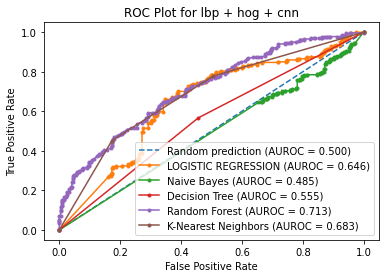

<Figure size 432x288 with 0 Axes>

In [36]:
#Plot the ROC curve
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='LOGISTIC REGRESSION (AUROC = %0.3f)' % logistic_auc)
plt.plot(gnb_fpr, gnb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % gnb_auc)
plt.plot(DTC_fpr, DTC_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % DTC_auc)
plt.plot(RFC_fpr, RFC_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % RFC_auc)
plt.plot(neigh_fpr, neigh_tpr, marker='.', label='K-Nearest Neighbors (AUROC = %0.3f)' % neigh_auc)

# Title
plt.title('ROC Plot for lbp + hog + cnn')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()
plt.savefig('ROC curve for lbp + hog + cnn')